# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

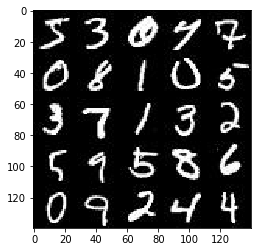

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

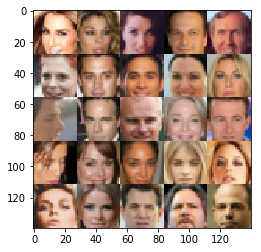

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


C:\ProgramData\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\ipykernel\__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_image = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="inputs_image")
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="inputs_z")
    lr = tf.placeholder(tf.float32, name="lr")
    return inputs_image, inputs_z, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
from functools import reduce

def discriminator(images, reuse=False):
    
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)

    """

    with tf.variable_scope('discriminator', reuse=reuse):
        
        # 1st layer, where leaky relu has the hyperparameter 0.1 and it is different from other layers
        # if you modify any hyperparameter below, it is highly probable that you cannot get the result
        # also, the first layer should not add batch_normalization, which is mentioned in the video while reason is not cleared
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(0.1 * conv1, conv1)
        dropout1 = tf.layers.dropout(relu1, rate=0.5)
        
        conv2 = tf.layers.conv2d(dropout1, 128, 5, strides=2, padding='same')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(0.01 * batch_norm2, batch_norm2)
        dropout2 = tf.layers.dropout(relu2, rate=0.5)
        
        conv3 = tf.layers.conv2d(dropout2, 256, 5, strides=2, padding='same')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(0.01 * batch_norm3, batch_norm3)
        dropout3 = tf.layers.dropout(relu3, rate=0.5)
        
        flat = tf.reshape(dropout3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)  
        
    return logits, out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    
    """
        
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        alpha = 0.1
        drop = 0.5 if is_train is True else 1.0
            
        # 1st layer
        g1 = tf.layers.dense(z, 7 * 7 * 512)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        batch_norm1 = tf.layers.batch_normalization(g1, training=is_train)
        relu1 = tf.maximum(alpha * batch_norm1, batch_norm1)
        dropout1 = tf.layers.dropout(relu1, rate=0.5)
        
        # 2nd layer
        g2 = tf.layers.conv2d_transpose(dropout1, 256, 5, strides=2, padding='same')
        batch_norm2 = tf.layers.batch_normalization(g2, training=is_train)
        relu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        dropout2 = tf.layers.dropout(relu2, rate=0.5)
        
        logits = tf.layers.conv2d_transpose(dropout2, out_channel_dim, 5, strides=2, padding='same')

        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.01
    
    input_fake = generator(input_z, out_channel_dim, is_train=True)
    d_logits_real, out = discriminator(input_real, reuse=False)
    d_logits_fake, out = discriminator(input_fake, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # not sure the meaning
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    image_width, image_height, image_channels = data_shape[1:]  
    
    inputs_image, inputs_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(inputs_image, inputs_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    samples, losses = [], []
    print_every = 10
    show_every = 100
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)) # the size here refer to output size
                _ = sess.run(d_train_opt, feed_dict={inputs_image: batch_images, inputs_z: batch_z, lr:learning_rate})
                # why I need to add inputs_image in g_loss? if not, error would be reported
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, lr:learning_rate, inputs_image: batch_images}) 
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({inputs_image: batch_images, inputs_z: batch_z})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, inputs_z, image_channels, data_image_mode)
    
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1) L
Epoch 1/2... Discriminator Loss: 0.6211... Generator Loss: 2.5737
Epoch 1/2... Discriminator Loss: 1.9040... Generator Loss: 0.2550
Epoch 1/2... Discriminator Loss: 0.8929... Generator Loss: 0.9732
Epoch 1/2... Discriminator Loss: 1.1261... Generator Loss: 0.8154
Epoch 1/2... Discriminator Loss: 1.0351... Generator Loss: 0.8258
Epoch 1/2... Discriminator Loss: 0.9961... Generator Loss: 0.6972
Epoch 1/2... Discriminator Loss: 0.9583... Generator Loss: 0.7535
Epoch 1/2... Discriminator Loss: 0.8136... Generator Loss: 2.1513
Epoch 1/2... Discriminator Loss: 0.8511... Generator Loss: 0.7476
Epoch 1/2... Discriminator Loss: 0.5654... Generator Loss: 1.6879


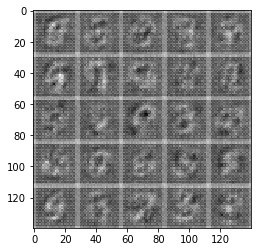

Epoch 1/2... Discriminator Loss: 0.5738... Generator Loss: 1.0913
Epoch 1/2... Discriminator Loss: 0.3914... Generator Loss: 2.8787
Epoch 1/2... Discriminator Loss: 0.4858... Generator Loss: 1.3134
Epoch 1/2... Discriminator Loss: 0.1072... Generator Loss: 3.5401
Epoch 1/2... Discriminator Loss: 0.1803... Generator Loss: 4.7338
Epoch 1/2... Discriminator Loss: 0.3291... Generator Loss: 1.8210
Epoch 1/2... Discriminator Loss: 0.4076... Generator Loss: 2.0387
Epoch 1/2... Discriminator Loss: 0.2051... Generator Loss: 2.4543
Epoch 1/2... Discriminator Loss: 0.6505... Generator Loss: 1.3482
Epoch 1/2... Discriminator Loss: 0.2310... Generator Loss: 2.4192


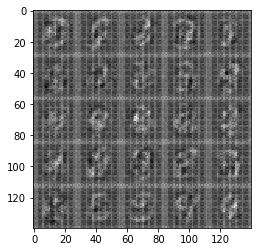

Epoch 1/2... Discriminator Loss: 0.4598... Generator Loss: 3.8043
Epoch 1/2... Discriminator Loss: 0.4418... Generator Loss: 1.4810
Epoch 1/2... Discriminator Loss: 0.3304... Generator Loss: 1.7829
Epoch 1/2... Discriminator Loss: 1.3131... Generator Loss: 0.4019
Epoch 1/2... Discriminator Loss: 0.1977... Generator Loss: 4.2654
Epoch 1/2... Discriminator Loss: 0.1822... Generator Loss: 2.7902
Epoch 1/2... Discriminator Loss: 0.2691... Generator Loss: 2.2028
Epoch 1/2... Discriminator Loss: 0.2451... Generator Loss: 4.8168
Epoch 1/2... Discriminator Loss: 0.3080... Generator Loss: 1.8192
Epoch 1/2... Discriminator Loss: 0.8452... Generator Loss: 0.7505


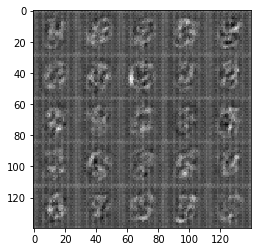

Epoch 1/2... Discriminator Loss: 0.4718... Generator Loss: 1.4101
Epoch 1/2... Discriminator Loss: 0.4716... Generator Loss: 1.8653
Epoch 1/2... Discriminator Loss: 0.1222... Generator Loss: 4.2092
Epoch 1/2... Discriminator Loss: 0.2004... Generator Loss: 2.6561
Epoch 1/2... Discriminator Loss: 0.1798... Generator Loss: 3.6950
Epoch 1/2... Discriminator Loss: 0.1604... Generator Loss: 4.2815
Epoch 1/2... Discriminator Loss: 0.1324... Generator Loss: 4.7604
Epoch 1/2... Discriminator Loss: 0.1340... Generator Loss: 3.2345
Epoch 1/2... Discriminator Loss: 1.7043... Generator Loss: 0.3260
Epoch 1/2... Discriminator Loss: 0.3677... Generator Loss: 1.8111


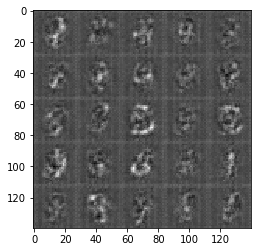

Epoch 1/2... Discriminator Loss: 0.2836... Generator Loss: 1.9391
Epoch 1/2... Discriminator Loss: 0.2207... Generator Loss: 2.4356
Epoch 1/2... Discriminator Loss: 0.3007... Generator Loss: 1.9252
Epoch 1/2... Discriminator Loss: 0.1676... Generator Loss: 2.8003
Epoch 1/2... Discriminator Loss: 0.1278... Generator Loss: 3.2608
Epoch 1/2... Discriminator Loss: 0.1529... Generator Loss: 3.1876
Epoch 1/2... Discriminator Loss: 0.4405... Generator Loss: 1.4524
Epoch 1/2... Discriminator Loss: 0.4134... Generator Loss: 1.6487
Epoch 1/2... Discriminator Loss: 0.3090... Generator Loss: 2.1441
Epoch 1/2... Discriminator Loss: 0.2096... Generator Loss: 2.4053


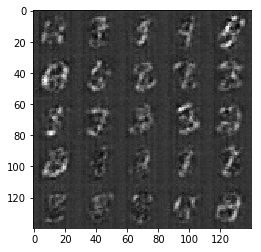

Epoch 1/2... Discriminator Loss: 0.3125... Generator Loss: 1.9950
Epoch 1/2... Discriminator Loss: 0.3001... Generator Loss: 1.8975
Epoch 1/2... Discriminator Loss: 0.2394... Generator Loss: 2.2089
Epoch 1/2... Discriminator Loss: 0.1847... Generator Loss: 2.5013
Epoch 1/2... Discriminator Loss: 0.2199... Generator Loss: 2.2196
Epoch 1/2... Discriminator Loss: 0.2155... Generator Loss: 2.4880
Epoch 1/2... Discriminator Loss: 0.1927... Generator Loss: 2.7302
Epoch 1/2... Discriminator Loss: 0.1525... Generator Loss: 2.8485
Epoch 1/2... Discriminator Loss: 0.1185... Generator Loss: 3.3505
Epoch 1/2... Discriminator Loss: 0.1214... Generator Loss: 3.1937


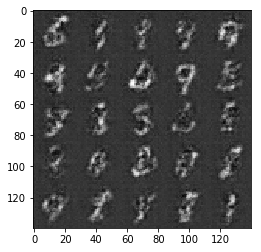

Epoch 1/2... Discriminator Loss: 0.1459... Generator Loss: 3.1418
Epoch 1/2... Discriminator Loss: 0.1440... Generator Loss: 2.9292
Epoch 1/2... Discriminator Loss: 0.1548... Generator Loss: 2.8466
Epoch 1/2... Discriminator Loss: 0.1288... Generator Loss: 3.3838
Epoch 1/2... Discriminator Loss: 0.1146... Generator Loss: 3.4569
Epoch 1/2... Discriminator Loss: 0.1312... Generator Loss: 3.0519
Epoch 1/2... Discriminator Loss: 0.1360... Generator Loss: 3.1092
Epoch 1/2... Discriminator Loss: 0.1976... Generator Loss: 2.3227
Epoch 1/2... Discriminator Loss: 0.0837... Generator Loss: 4.1394
Epoch 1/2... Discriminator Loss: 0.0936... Generator Loss: 4.1391


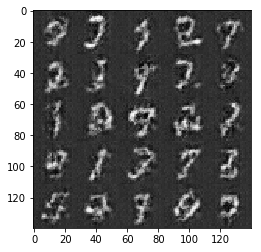

Epoch 1/2... Discriminator Loss: 0.1033... Generator Loss: 3.7079
Epoch 1/2... Discriminator Loss: 0.1010... Generator Loss: 3.6284
Epoch 1/2... Discriminator Loss: 0.0948... Generator Loss: 3.8035
Epoch 1/2... Discriminator Loss: 0.0809... Generator Loss: 4.4287
Epoch 1/2... Discriminator Loss: 0.1029... Generator Loss: 4.1042
Epoch 1/2... Discriminator Loss: 0.2978... Generator Loss: 2.6694
Epoch 1/2... Discriminator Loss: 0.3817... Generator Loss: 1.6383
Epoch 1/2... Discriminator Loss: 0.4765... Generator Loss: 1.3262
Epoch 1/2... Discriminator Loss: 0.2994... Generator Loss: 1.8262
Epoch 1/2... Discriminator Loss: 0.5050... Generator Loss: 1.2279


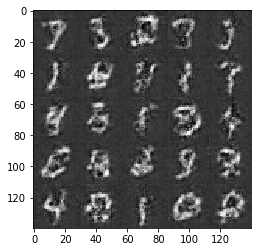

Epoch 1/2... Discriminator Loss: 0.1949... Generator Loss: 2.4186
Epoch 1/2... Discriminator Loss: 0.2177... Generator Loss: 2.1778
Epoch 1/2... Discriminator Loss: 0.1630... Generator Loss: 2.7115
Epoch 1/2... Discriminator Loss: 0.2645... Generator Loss: 1.8590
Epoch 1/2... Discriminator Loss: 0.0916... Generator Loss: 3.9811
Epoch 1/2... Discriminator Loss: 0.1279... Generator Loss: 3.2852
Epoch 1/2... Discriminator Loss: 0.1793... Generator Loss: 2.4394
Epoch 1/2... Discriminator Loss: 0.1418... Generator Loss: 2.9765
Epoch 1/2... Discriminator Loss: 0.1610... Generator Loss: 2.6588
Epoch 1/2... Discriminator Loss: 0.1092... Generator Loss: 3.5893


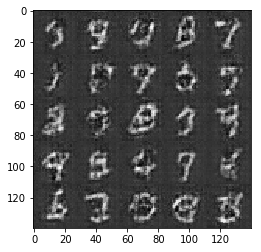

Epoch 1/2... Discriminator Loss: 0.1172... Generator Loss: 3.3164
Epoch 1/2... Discriminator Loss: 7.6949... Generator Loss: 0.0019
Epoch 1/2... Discriminator Loss: 0.8509... Generator Loss: 1.7073
Epoch 2/2... Discriminator Loss: 1.2216... Generator Loss: 4.0923
Epoch 2/2... Discriminator Loss: 0.3575... Generator Loss: 1.7860
Epoch 2/2... Discriminator Loss: 0.2881... Generator Loss: 1.8700
Epoch 2/2... Discriminator Loss: 0.5445... Generator Loss: 1.1246
Epoch 2/2... Discriminator Loss: 0.4161... Generator Loss: 1.4456
Epoch 2/2... Discriminator Loss: 0.2114... Generator Loss: 2.3451
Epoch 2/2... Discriminator Loss: 0.3628... Generator Loss: 1.5980


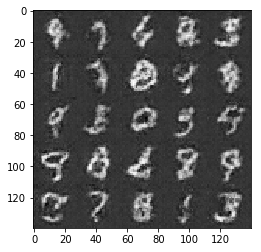

Epoch 2/2... Discriminator Loss: 0.1739... Generator Loss: 2.7133
Epoch 2/2... Discriminator Loss: 0.1120... Generator Loss: 3.3768
Epoch 2/2... Discriminator Loss: 0.1783... Generator Loss: 2.4703
Epoch 2/2... Discriminator Loss: 0.1608... Generator Loss: 2.8885
Epoch 2/2... Discriminator Loss: 0.0990... Generator Loss: 3.7401
Epoch 2/2... Discriminator Loss: 0.1261... Generator Loss: 3.0439
Epoch 2/2... Discriminator Loss: 0.2047... Generator Loss: 4.4494
Epoch 2/2... Discriminator Loss: 0.1138... Generator Loss: 3.2741
Epoch 2/2... Discriminator Loss: 0.0909... Generator Loss: 4.3483
Epoch 2/2... Discriminator Loss: 0.1150... Generator Loss: 3.2450


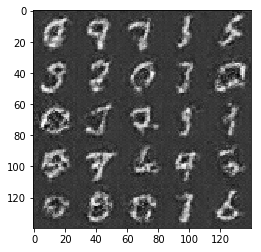

Epoch 2/2... Discriminator Loss: 0.0806... Generator Loss: 4.5288
Epoch 2/2... Discriminator Loss: 0.1248... Generator Loss: 3.0287
Epoch 2/2... Discriminator Loss: 0.0761... Generator Loss: 4.6673
Epoch 2/2... Discriminator Loss: 0.0894... Generator Loss: 3.7771
Epoch 2/2... Discriminator Loss: 0.0768... Generator Loss: 4.5643
Epoch 2/2... Discriminator Loss: 0.0944... Generator Loss: 3.8425
Epoch 2/2... Discriminator Loss: 0.0968... Generator Loss: 3.5860
Epoch 2/2... Discriminator Loss: 0.2449... Generator Loss: 2.1275
Epoch 2/2... Discriminator Loss: 1.0934... Generator Loss: 0.7881
Epoch 2/2... Discriminator Loss: 0.3934... Generator Loss: 1.5820


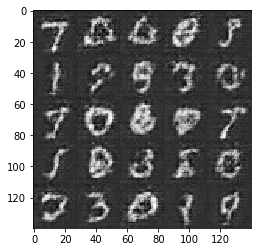

Epoch 2/2... Discriminator Loss: 0.2487... Generator Loss: 2.4976
Epoch 2/2... Discriminator Loss: 0.3396... Generator Loss: 1.6725
Epoch 2/2... Discriminator Loss: 0.2947... Generator Loss: 1.9953
Epoch 2/2... Discriminator Loss: 0.1676... Generator Loss: 2.6342
Epoch 2/2... Discriminator Loss: 0.3939... Generator Loss: 1.5189
Epoch 2/2... Discriminator Loss: 0.3050... Generator Loss: 1.7515
Epoch 2/2... Discriminator Loss: 0.3311... Generator Loss: 1.7564
Epoch 2/2... Discriminator Loss: 0.3871... Generator Loss: 1.5290
Epoch 2/2... Discriminator Loss: 0.2135... Generator Loss: 2.2690
Epoch 2/2... Discriminator Loss: 0.3486... Generator Loss: 1.7140


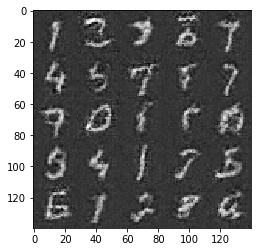

Epoch 2/2... Discriminator Loss: 0.2002... Generator Loss: 2.4392
Epoch 2/2... Discriminator Loss: 0.1946... Generator Loss: 2.3988
Epoch 2/2... Discriminator Loss: 0.1712... Generator Loss: 2.6334
Epoch 2/2... Discriminator Loss: 0.2973... Generator Loss: 1.9168
Epoch 2/2... Discriminator Loss: 0.2357... Generator Loss: 2.0981
Epoch 2/2... Discriminator Loss: 0.1662... Generator Loss: 2.5901
Epoch 2/2... Discriminator Loss: 0.1383... Generator Loss: 3.2462
Epoch 2/2... Discriminator Loss: 0.1954... Generator Loss: 2.3120
Epoch 2/2... Discriminator Loss: 0.2423... Generator Loss: 2.0959
Epoch 2/2... Discriminator Loss: 0.2742... Generator Loss: 1.9325


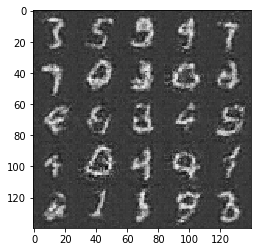

Epoch 2/2... Discriminator Loss: 0.1780... Generator Loss: 2.5395
Epoch 2/2... Discriminator Loss: 0.1726... Generator Loss: 2.5041
Epoch 2/2... Discriminator Loss: 0.1628... Generator Loss: 2.6354
Epoch 2/2... Discriminator Loss: 0.1225... Generator Loss: 3.2197
Epoch 2/2... Discriminator Loss: 0.1692... Generator Loss: 2.7412
Epoch 2/2... Discriminator Loss: 0.0819... Generator Loss: 4.3015
Epoch 2/2... Discriminator Loss: 0.0937... Generator Loss: 3.7684
Epoch 2/2... Discriminator Loss: 0.1030... Generator Loss: 3.6163
Epoch 2/2... Discriminator Loss: 0.1698... Generator Loss: 2.6066
Epoch 2/2... Discriminator Loss: 0.0721... Generator Loss: 4.7070


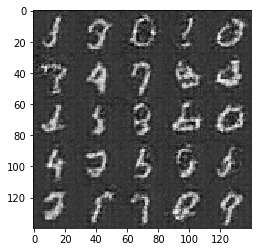

Epoch 2/2... Discriminator Loss: 0.2743... Generator Loss: 2.0288
Epoch 2/2... Discriminator Loss: 0.0814... Generator Loss: 4.3705
Epoch 2/2... Discriminator Loss: 0.0774... Generator Loss: 4.3931
Epoch 2/2... Discriminator Loss: 0.1149... Generator Loss: 3.3133
Epoch 2/2... Discriminator Loss: 0.0932... Generator Loss: 3.8302
Epoch 2/2... Discriminator Loss: 0.1049... Generator Loss: 3.8756
Epoch 2/2... Discriminator Loss: 0.0782... Generator Loss: 4.4368
Epoch 2/2... Discriminator Loss: 0.1038... Generator Loss: 3.6227
Epoch 2/2... Discriminator Loss: 0.1558... Generator Loss: 2.7810
Epoch 2/2... Discriminator Loss: 0.2821... Generator Loss: 1.9422


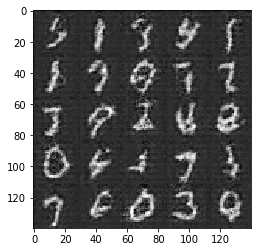

Epoch 2/2... Discriminator Loss: 0.2046... Generator Loss: 2.3870
Epoch 2/2... Discriminator Loss: 11.4576... Generator Loss: 13.4912
Epoch 2/2... Discriminator Loss: 1.1991... Generator Loss: 0.7189
Epoch 2/2... Discriminator Loss: 1.0806... Generator Loss: 0.9171
Epoch 2/2... Discriminator Loss: 0.9579... Generator Loss: 0.8324
Epoch 2/2... Discriminator Loss: 1.1251... Generator Loss: 0.7962
Epoch 2/2... Discriminator Loss: 0.9246... Generator Loss: 1.0614
Epoch 2/2... Discriminator Loss: 0.7875... Generator Loss: 1.2729
Epoch 2/2... Discriminator Loss: 1.0824... Generator Loss: 0.6268
Epoch 2/2... Discriminator Loss: 0.7763... Generator Loss: 1.1026


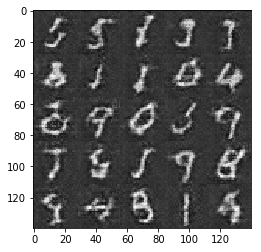

Epoch 2/2... Discriminator Loss: 1.3199... Generator Loss: 0.4516
Epoch 2/2... Discriminator Loss: 0.7949... Generator Loss: 0.9307
Epoch 2/2... Discriminator Loss: 0.7113... Generator Loss: 1.2780
Epoch 2/2... Discriminator Loss: 0.5807... Generator Loss: 1.3084
Epoch 2/2... Discriminator Loss: 0.5031... Generator Loss: 2.1765
Epoch 2/2... Discriminator Loss: 0.5496... Generator Loss: 2.7530
Epoch 2/2... Discriminator Loss: 0.3588... Generator Loss: 1.7812
Epoch 2/2... Discriminator Loss: 1.5234... Generator Loss: 0.4121
Epoch 2/2... Discriminator Loss: 0.2832... Generator Loss: 2.6062
Epoch 2/2... Discriminator Loss: 0.3188... Generator Loss: 2.1033


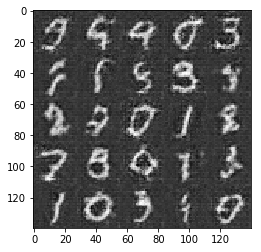

Epoch 2/2... Discriminator Loss: 0.3516... Generator Loss: 2.0196
Epoch 2/2... Discriminator Loss: 0.5695... Generator Loss: 1.0995
Epoch 2/2... Discriminator Loss: 0.2518... Generator Loss: 2.1516
Epoch 2/2... Discriminator Loss: 2.2111... Generator Loss: 0.1670
Epoch 2/2... Discriminator Loss: 0.3097... Generator Loss: 2.0695
Epoch 2/2... Discriminator Loss: 0.3244... Generator Loss: 1.7514
Epoch 2/2... Discriminator Loss: 0.1869... Generator Loss: 2.5541


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    print(mnist_dataset.shape, mnist_dataset.image_mode)
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3) RGB
Epoch 1/1... Discriminator Loss: 0.0824... Generator Loss: 10.5025
Epoch 1/1... Discriminator Loss: 3.2930... Generator Loss: 0.4375
Epoch 1/1... Discriminator Loss: 0.2154... Generator Loss: 3.0568
Epoch 1/1... Discriminator Loss: 0.1961... Generator Loss: 8.0990
Epoch 1/1... Discriminator Loss: 0.5509... Generator Loss: 6.3748
Epoch 1/1... Discriminator Loss: 2.7145... Generator Loss: 7.2380
Epoch 1/1... Discriminator Loss: 0.6496... Generator Loss: 1.3025
Epoch 1/1... Discriminator Loss: 0.5789... Generator Loss: 1.3632
Epoch 1/1... Discriminator Loss: 0.1636... Generator Loss: 3.1811
Epoch 1/1... Discriminator Loss: 0.0885... Generator Loss: 4.6317


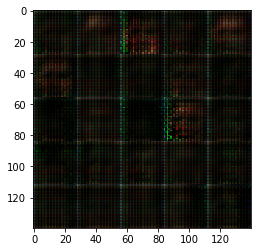

Epoch 1/1... Discriminator Loss: 0.0863... Generator Loss: 4.3081
Epoch 1/1... Discriminator Loss: 0.1463... Generator Loss: 5.6064
Epoch 1/1... Discriminator Loss: 0.1033... Generator Loss: 3.5017
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 1.0717
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.5629
Epoch 1/1... Discriminator Loss: 1.6522... Generator Loss: 0.3085
Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 3.4232
Epoch 1/1... Discriminator Loss: 0.1371... Generator Loss: 2.9933
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.6077


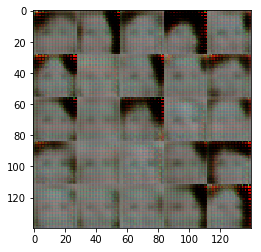

Epoch 1/1... Discriminator Loss: 0.1662... Generator Loss: 2.9321
Epoch 1/1... Discriminator Loss: 0.0863... Generator Loss: 3.8799
Epoch 1/1... Discriminator Loss: 0.0736... Generator Loss: 6.1823
Epoch 1/1... Discriminator Loss: 0.0940... Generator Loss: 3.6536
Epoch 1/1... Discriminator Loss: 0.0851... Generator Loss: 4.1683
Epoch 1/1... Discriminator Loss: 0.0681... Generator Loss: 4.8667
Epoch 1/1... Discriminator Loss: 0.0785... Generator Loss: 4.2302
Epoch 1/1... Discriminator Loss: 0.0643... Generator Loss: 5.3088
Epoch 1/1... Discriminator Loss: 0.0743... Generator Loss: 4.5863
Epoch 1/1... Discriminator Loss: 0.0608... Generator Loss: 7.0109


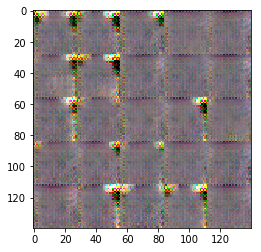

Epoch 1/1... Discriminator Loss: 0.0615... Generator Loss: 5.7723
Epoch 1/1... Discriminator Loss: 0.0727... Generator Loss: 4.6445
Epoch 1/1... Discriminator Loss: 0.1071... Generator Loss: 4.0139
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 1.6013
Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 0.9728
Epoch 1/1... Discriminator Loss: 0.7137... Generator Loss: 2.2601
Epoch 1/1... Discriminator Loss: 0.5176... Generator Loss: 3.9425
Epoch 1/1... Discriminator Loss: 0.3565... Generator Loss: 2.3913
Epoch 1/1... Discriminator Loss: 0.3479... Generator Loss: 2.2780
Epoch 1/1... Discriminator Loss: 0.1642... Generator Loss: 2.8829


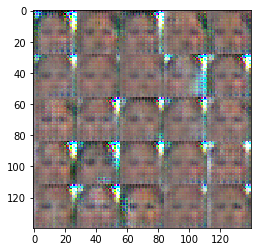

Epoch 1/1... Discriminator Loss: 0.0816... Generator Loss: 4.1365
Epoch 1/1... Discriminator Loss: 0.0992... Generator Loss: 3.4927
Epoch 1/1... Discriminator Loss: 0.4639... Generator Loss: 3.1835
Epoch 1/1... Discriminator Loss: 0.1369... Generator Loss: 3.1305
Epoch 1/1... Discriminator Loss: 0.1248... Generator Loss: 3.3985
Epoch 1/1... Discriminator Loss: 0.1046... Generator Loss: 3.7569
Epoch 1/1... Discriminator Loss: 0.1066... Generator Loss: 3.4401
Epoch 1/1... Discriminator Loss: 0.0913... Generator Loss: 3.8990
Epoch 1/1... Discriminator Loss: 0.0926... Generator Loss: 3.9049
Epoch 1/1... Discriminator Loss: 0.0657... Generator Loss: 5.9641


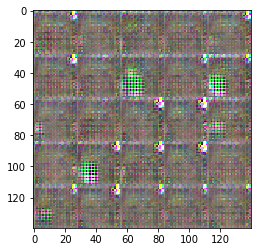

Epoch 1/1... Discriminator Loss: 0.0724... Generator Loss: 4.6717
Epoch 1/1... Discriminator Loss: 0.0662... Generator Loss: 5.2471
Epoch 1/1... Discriminator Loss: 0.0633... Generator Loss: 5.5581
Epoch 1/1... Discriminator Loss: 0.0686... Generator Loss: 4.9168
Epoch 1/1... Discriminator Loss: 0.0640... Generator Loss: 5.4497
Epoch 1/1... Discriminator Loss: 0.0689... Generator Loss: 4.7099
Epoch 1/1... Discriminator Loss: 0.0631... Generator Loss: 5.3875
Epoch 1/1... Discriminator Loss: 0.0566... Generator Loss: 11.1564
Epoch 1/1... Discriminator Loss: 0.0596... Generator Loss: 7.8855
Epoch 1/1... Discriminator Loss: 0.0612... Generator Loss: 6.0752


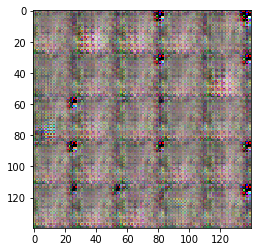

Epoch 1/1... Discriminator Loss: 0.0593... Generator Loss: 15.1319
Epoch 1/1... Discriminator Loss: 4.1942... Generator Loss: 0.1517
Epoch 1/1... Discriminator Loss: 0.7415... Generator Loss: 1.2845
Epoch 1/1... Discriminator Loss: 1.9986... Generator Loss: 0.2493
Epoch 1/1... Discriminator Loss: 2.5333... Generator Loss: 0.1748
Epoch 1/1... Discriminator Loss: 1.7204... Generator Loss: 0.3943
Epoch 1/1... Discriminator Loss: 0.5489... Generator Loss: 1.1733
Epoch 1/1... Discriminator Loss: 5.4281... Generator Loss: 7.5868
Epoch 1/1... Discriminator Loss: 1.7783... Generator Loss: 0.2803
Epoch 1/1... Discriminator Loss: 0.9202... Generator Loss: 1.6327


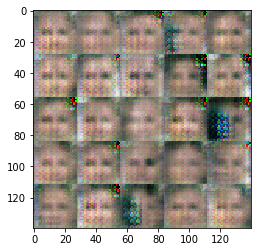

Epoch 1/1... Discriminator Loss: 0.5141... Generator Loss: 1.3249
Epoch 1/1... Discriminator Loss: 0.3676... Generator Loss: 2.6898
Epoch 1/1... Discriminator Loss: 0.7078... Generator Loss: 1.4253
Epoch 1/1... Discriminator Loss: 0.2660... Generator Loss: 2.2492
Epoch 1/1... Discriminator Loss: 0.1250... Generator Loss: 4.1164
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 5.5210
Epoch 1/1... Discriminator Loss: 0.1750... Generator Loss: 3.2205
Epoch 1/1... Discriminator Loss: 1.6129... Generator Loss: 1.0652
Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 1.0504
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.6736


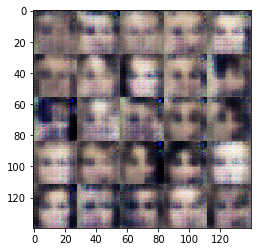

Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 1.7605
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.5096
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 2.0047... Generator Loss: 0.2125
Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 0.1515... Generator Loss: 3.3158
Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 2.6130
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 1.4857


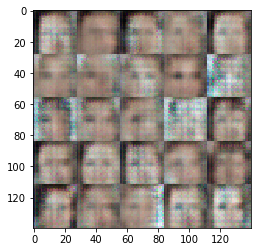

Epoch 1/1... Discriminator Loss: 0.5139... Generator Loss: 1.4598
Epoch 1/1... Discriminator Loss: 0.9661... Generator Loss: 3.7304
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.6367
Epoch 1/1... Discriminator Loss: 0.3225... Generator Loss: 3.7013
Epoch 1/1... Discriminator Loss: 0.7735... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 0.0789... Generator Loss: 6.0117
Epoch 1/1... Discriminator Loss: 0.0593... Generator Loss: 7.4334
Epoch 1/1... Discriminator Loss: 0.2260... Generator Loss: 2.1540
Epoch 1/1... Discriminator Loss: 0.0726... Generator Loss: 4.6963
Epoch 1/1... Discriminator Loss: 0.0675... Generator Loss: 5.5894


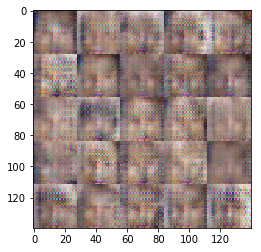

Epoch 1/1... Discriminator Loss: 0.1246... Generator Loss: 3.3037
Epoch 1/1... Discriminator Loss: 0.0602... Generator Loss: 8.1235
Epoch 1/1... Discriminator Loss: 0.0674... Generator Loss: 6.5760
Epoch 1/1... Discriminator Loss: 0.0620... Generator Loss: 8.4161
Epoch 1/1... Discriminator Loss: 0.0656... Generator Loss: 5.6338
Epoch 1/1... Discriminator Loss: 0.0791... Generator Loss: 4.4984
Epoch 1/1... Discriminator Loss: 0.0833... Generator Loss: 4.2088
Epoch 1/1... Discriminator Loss: 0.0628... Generator Loss: 6.6080
Epoch 1/1... Discriminator Loss: 0.0788... Generator Loss: 4.4973
Epoch 1/1... Discriminator Loss: 0.0592... Generator Loss: 7.3019


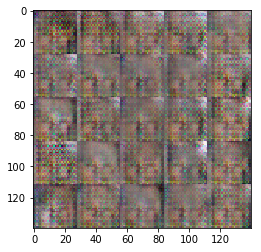

Epoch 1/1... Discriminator Loss: 0.0588... Generator Loss: 8.9813
Epoch 1/1... Discriminator Loss: 0.0611... Generator Loss: 6.2414
Epoch 1/1... Discriminator Loss: 0.0590... Generator Loss: 7.8276
Epoch 1/1... Discriminator Loss: 0.0787... Generator Loss: 4.3269
Epoch 1/1... Discriminator Loss: 0.0815... Generator Loss: 4.3650
Epoch 1/1... Discriminator Loss: 0.0618... Generator Loss: 6.5215
Epoch 1/1... Discriminator Loss: 0.0723... Generator Loss: 4.5540
Epoch 1/1... Discriminator Loss: 0.0758... Generator Loss: 4.5664
Epoch 1/1... Discriminator Loss: 0.0830... Generator Loss: 4.1083
Epoch 1/1... Discriminator Loss: 0.0708... Generator Loss: 5.0734


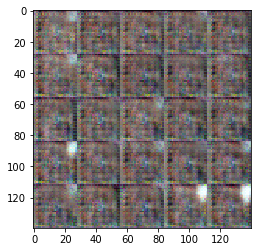

Epoch 1/1... Discriminator Loss: 0.0610... Generator Loss: 7.0209
Epoch 1/1... Discriminator Loss: 0.4598... Generator Loss: 2.8129
Epoch 1/1... Discriminator Loss: 0.5019... Generator Loss: 1.2489
Epoch 1/1... Discriminator Loss: 0.0809... Generator Loss: 4.9745
Epoch 1/1... Discriminator Loss: 0.1084... Generator Loss: 3.9874
Epoch 1/1... Discriminator Loss: 3.7645... Generator Loss: 0.0334
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 1.0231
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 1.1964
Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 1.0876
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 0.9678


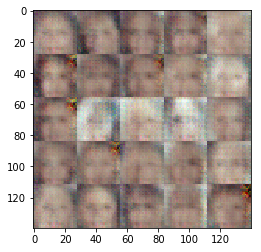

Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 1.5057
Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 0.9137
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.5029
Epoch 1/1... Discriminator Loss: 1.0044... Generator Loss: 0.9355
Epoch 1/1... Discriminator Loss: 0.9986... Generator Loss: 1.5641
Epoch 1/1... Discriminator Loss: 1.5786... Generator Loss: 0.4732
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 1.2326
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.5760
Epoch 1/1... Discriminator Loss: 0.8326... Generator Loss: 2.7895
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.4823


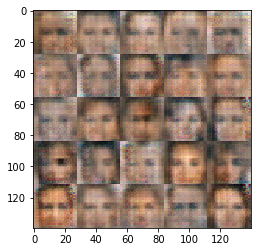

Epoch 1/1... Discriminator Loss: 0.7516... Generator Loss: 1.3007
Epoch 1/1... Discriminator Loss: 0.1080... Generator Loss: 4.8860
Epoch 1/1... Discriminator Loss: 2.6642... Generator Loss: 2.0776
Epoch 1/1... Discriminator Loss: 0.5820... Generator Loss: 2.5127
Epoch 1/1... Discriminator Loss: 0.7991... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 2.0137... Generator Loss: 0.1981
Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 0.8900... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 0.6678... Generator Loss: 1.2110
Epoch 1/1... Discriminator Loss: 0.7316... Generator Loss: 1.6826


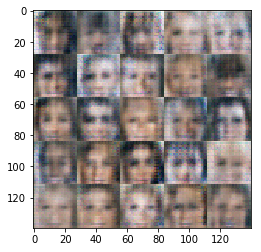

Epoch 1/1... Discriminator Loss: 0.1288... Generator Loss: 3.5597
Epoch 1/1... Discriminator Loss: 0.7885... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 0.4818... Generator Loss: 2.0091
Epoch 1/1... Discriminator Loss: 0.3944... Generator Loss: 2.9156
Epoch 1/1... Discriminator Loss: 0.1717... Generator Loss: 2.6779
Epoch 1/1... Discriminator Loss: 3.4141... Generator Loss: 2.8334
Epoch 1/1... Discriminator Loss: 0.4673... Generator Loss: 3.2819
Epoch 1/1... Discriminator Loss: 0.6285... Generator Loss: 6.1972
Epoch 1/1... Discriminator Loss: 0.0930... Generator Loss: 3.7919
Epoch 1/1... Discriminator Loss: 0.0988... Generator Loss: 4.4731


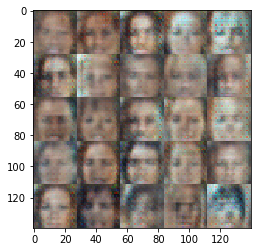

Epoch 1/1... Discriminator Loss: 0.1713... Generator Loss: 2.3893
Epoch 1/1... Discriminator Loss: 0.1133... Generator Loss: 3.3223
Epoch 1/1... Discriminator Loss: 0.5944... Generator Loss: 3.2912
Epoch 1/1... Discriminator Loss: 0.3617... Generator Loss: 3.0869
Epoch 1/1... Discriminator Loss: 2.1372... Generator Loss: 0.1786
Epoch 1/1... Discriminator Loss: 0.1915... Generator Loss: 6.1425
Epoch 1/1... Discriminator Loss: 0.2131... Generator Loss: 3.7523
Epoch 1/1... Discriminator Loss: 0.4893... Generator Loss: 1.2129
Epoch 1/1... Discriminator Loss: 0.5203... Generator Loss: 1.5189
Epoch 1/1... Discriminator Loss: 0.1381... Generator Loss: 3.6853


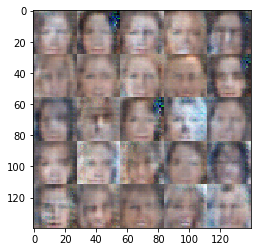

Epoch 1/1... Discriminator Loss: 0.5807... Generator Loss: 1.0949
Epoch 1/1... Discriminator Loss: 0.1965... Generator Loss: 2.4013
Epoch 1/1... Discriminator Loss: 0.1692... Generator Loss: 2.8274
Epoch 1/1... Discriminator Loss: 0.0689... Generator Loss: 4.9974
Epoch 1/1... Discriminator Loss: 0.0946... Generator Loss: 3.8809
Epoch 1/1... Discriminator Loss: 0.0713... Generator Loss: 5.2303
Epoch 1/1... Discriminator Loss: 0.1917... Generator Loss: 2.2726
Epoch 1/1... Discriminator Loss: 0.0816... Generator Loss: 4.0649
Epoch 1/1... Discriminator Loss: 0.1424... Generator Loss: 5.9525
Epoch 1/1... Discriminator Loss: 0.6582... Generator Loss: 0.9492


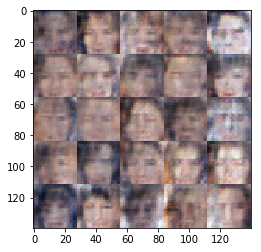

Epoch 1/1... Discriminator Loss: 1.8787... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 0.9452
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.6703... Generator Loss: 0.4031
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.4164
Epoch 1/1... Discriminator Loss: 0.5444... Generator Loss: 1.4237
Epoch 1/1... Discriminator Loss: 0.2935... Generator Loss: 2.3914


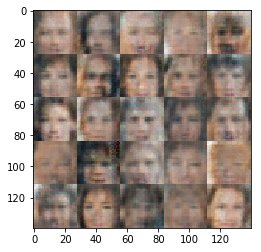

Epoch 1/1... Discriminator Loss: 1.7135... Generator Loss: 1.9323
Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 0.9400
Epoch 1/1... Discriminator Loss: 0.9255... Generator Loss: 1.6001
Epoch 1/1... Discriminator Loss: 0.3119... Generator Loss: 4.8134
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 0.4768... Generator Loss: 1.5615
Epoch 1/1... Discriminator Loss: 0.3545... Generator Loss: 1.6606
Epoch 1/1... Discriminator Loss: 0.6950... Generator Loss: 1.7084
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 0.6498


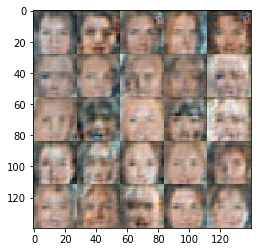

Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 0.3003... Generator Loss: 1.9880
Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 0.4967... Generator Loss: 1.9624
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.4811
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.8640
Epoch 1/1... Discriminator Loss: 0.6252... Generator Loss: 1.0640
Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 0.3867


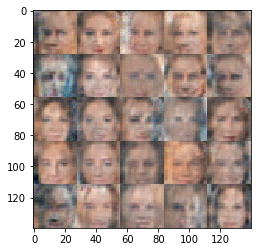

Epoch 1/1... Discriminator Loss: 0.8093... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 0.6882... Generator Loss: 1.4128
Epoch 1/1... Discriminator Loss: 0.9819... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.7686... Generator Loss: 0.2534
Epoch 1/1... Discriminator Loss: 0.8263... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 0.3512... Generator Loss: 1.9567
Epoch 1/1... Discriminator Loss: 0.1872... Generator Loss: 3.4616
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 1.0023
Epoch 1/1... Discriminator Loss: 0.6750... Generator Loss: 0.9858
Epoch 1/1... Discriminator Loss: 0.8609... Generator Loss: 1.1606


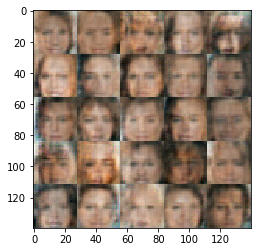

Epoch 1/1... Discriminator Loss: 0.7081... Generator Loss: 3.8836
Epoch 1/1... Discriminator Loss: 0.3226... Generator Loss: 1.8824
Epoch 1/1... Discriminator Loss: 1.6533... Generator Loss: 0.4521
Epoch 1/1... Discriminator Loss: 0.7900... Generator Loss: 1.0220
Epoch 1/1... Discriminator Loss: 1.5498... Generator Loss: 0.3318
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 1.0697
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 1.7886
Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 0.7339... Generator Loss: 1.3892


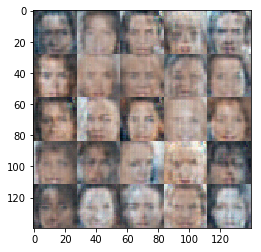

Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 0.9014... Generator Loss: 2.6164
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 1.3574
Epoch 1/1... Discriminator Loss: 1.9885... Generator Loss: 0.2074
Epoch 1/1... Discriminator Loss: 0.4400... Generator Loss: 1.6882
Epoch 1/1... Discriminator Loss: 1.6158... Generator Loss: 0.3283
Epoch 1/1... Discriminator Loss: 0.7880... Generator Loss: 1.0001
Epoch 1/1... Discriminator Loss: 0.6010... Generator Loss: 1.9198
Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 0.4404... Generator Loss: 3.0335


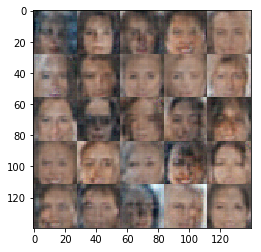

Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 1.5161
Epoch 1/1... Discriminator Loss: 0.7103... Generator Loss: 1.1178
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 0.8077... Generator Loss: 2.0052
Epoch 1/1... Discriminator Loss: 0.8886... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 0.1644... Generator Loss: 4.4481
Epoch 1/1... Discriminator Loss: 0.4762... Generator Loss: 1.4335
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.6253
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 1.3199


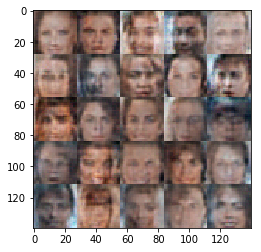

Epoch 1/1... Discriminator Loss: 0.6547... Generator Loss: 1.0932
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.4956... Generator Loss: 0.3979
Epoch 1/1... Discriminator Loss: 0.5659... Generator Loss: 1.4149
Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 1.9608
Epoch 1/1... Discriminator Loss: 0.5505... Generator Loss: 1.4584
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.5295
Epoch 1/1... Discriminator Loss: 1.5375... Generator Loss: 0.3786
Epoch 1/1... Discriminator Loss: 2.2043... Generator Loss: 0.1975


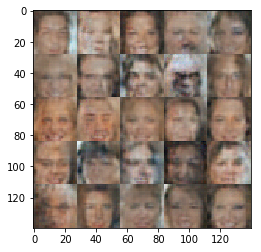

Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 2.1292... Generator Loss: 0.1949
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.5846
Epoch 1/1... Discriminator Loss: 0.6483... Generator Loss: 1.4734
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.4873
Epoch 1/1... Discriminator Loss: 0.7924... Generator Loss: 1.1270
Epoch 1/1... Discriminator Loss: 0.5488... Generator Loss: 1.3919
Epoch 1/1... Discriminator Loss: 1.6159... Generator Loss: 0.3559
Epoch 1/1... Discriminator Loss: 0.6529... Generator Loss: 1.1523
Epoch 1/1... Discriminator Loss: 2.4033... Generator Loss: 0.1344


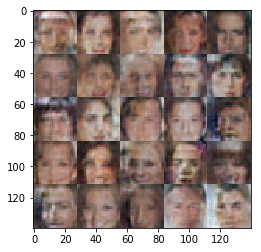

Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.5547
Epoch 1/1... Discriminator Loss: 2.4294... Generator Loss: 0.1495
Epoch 1/1... Discriminator Loss: 2.0370... Generator Loss: 0.2014
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 1.5536
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.4870
Epoch 1/1... Discriminator Loss: 0.3474... Generator Loss: 4.2410
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 1.6580
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.6144... Generator Loss: 0.3884
Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 1.2361


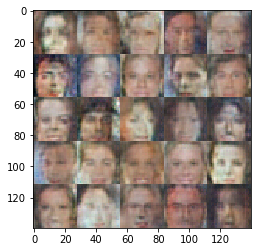

Epoch 1/1... Discriminator Loss: 1.5675... Generator Loss: 0.3275
Epoch 1/1... Discriminator Loss: 2.1780... Generator Loss: 0.1953
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.5535
Epoch 1/1... Discriminator Loss: 0.4064... Generator Loss: 2.4078
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 0.5877... Generator Loss: 3.5320
Epoch 1/1... Discriminator Loss: 0.9031... Generator Loss: 1.1223
Epoch 1/1... Discriminator Loss: 0.7888... Generator Loss: 1.1372
Epoch 1/1... Discriminator Loss: 0.9974... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 0.6839


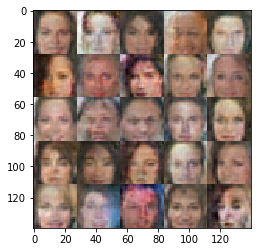

Epoch 1/1... Discriminator Loss: 1.8878... Generator Loss: 0.2368
Epoch 1/1... Discriminator Loss: 0.7840... Generator Loss: 0.9712
Epoch 1/1... Discriminator Loss: 0.5359... Generator Loss: 1.5273
Epoch 1/1... Discriminator Loss: 1.0636... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 0.7580... Generator Loss: 1.6408
Epoch 1/1... Discriminator Loss: 0.7620... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 0.4739... Generator Loss: 1.8922
Epoch 1/1... Discriminator Loss: 3.6195... Generator Loss: 0.0657
Epoch 1/1... Discriminator Loss: 0.7800... Generator Loss: 1.0573


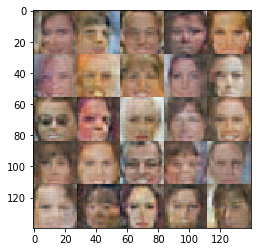

Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 1.2596
Epoch 1/1... Discriminator Loss: 2.2164... Generator Loss: 0.1995
Epoch 1/1... Discriminator Loss: 1.6857... Generator Loss: 0.4561
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.4950
Epoch 1/1... Discriminator Loss: 0.7466... Generator Loss: 0.9814
Epoch 1/1... Discriminator Loss: 1.7395... Generator Loss: 0.2892
Epoch 1/1... Discriminator Loss: 1.6657... Generator Loss: 0.3471
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.0818
Epoch 1/1... Discriminator Loss: 1.0299... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 2.2854... Generator Loss: 0.2064


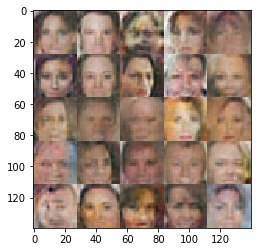

Epoch 1/1... Discriminator Loss: 1.9361... Generator Loss: 0.2288
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 0.5260
Epoch 1/1... Discriminator Loss: 0.4320... Generator Loss: 2.2982
Epoch 1/1... Discriminator Loss: 0.5968... Generator Loss: 1.1940
Epoch 1/1... Discriminator Loss: 1.5574... Generator Loss: 0.4065
Epoch 1/1... Discriminator Loss: 1.8117... Generator Loss: 0.2810


In [14]:
batch_size = 64         #cannot be modified / reason: ugly result
z_dim = 100             
learning_rate = 0.0002   #cannot be modified, the original is 0.002. If it is increased to 0.005, then the result is getting from good to desaster
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    print(celeba_dataset.shape, celeba_dataset.image_mode)
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.